#### Import Dependencies

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE, ADASYN

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


#### Data Dictionary

**Data Dictionary**

- pol_eff_dt - auto insurance policy effective date
- gender - gender of driver: F, M
- agecat - driver's age category: 1 (youngest), 2, 3, 4, 5, 6
- credit_score - driver’s credit score(integer): 1-100, 1=poor, 100=excellent
- area - driver's area of residence: A, B, C, D, E, F
- traffic_index - traffic index of driver’s area of residence(integer): 100=country average, >100 means worse traffic conditions than average
- veh_age - age of vehicle(categorical): 1 (youngest), 2, 3, 4
- veh_body - vehicle body, coded as:
    - BUS
    - CONVT = convertible  
    - COUPE   
    - HBACK = hatchback                  
    - HDTOP = hardtop
    - MCARA = motorized caravan
    - MIBUS = minibus
    - PANVN = panel van
    - RDSTR = roadster
    - SEDAN    
    - STNWG = station wagon
    - TRUCK           
    - UTE = utility
- veh_value - vehicle value, in \\$10,000s
- claim_office - office location of claim handling agent: A, B, C, D
- traffic2 - traffic index of driver’s area of residence(integer): 100=country average, >100 means worse traffic conditions than average.  Null values have imputed mean of full dataset
- veh_value2 - vehicle value, in \\$10,000s. Null values have been replaces with the mean of the full dataset
- veh_value3 - vehicle value, in \\$10,000s. Null values have been replaces with the median of the full dataset
- veh_age2 - age of vehicle(categorical): 1 (youngest), 2, 3, 4.  Null values have been replaces with the most frequent category, which is 2
- credit2 - driver’s credit score(integer): 1-100, 1=poor, 100=excellent. Null values have been replaces with the mean of the full dataset
- credit3 - driver’s credit score(integer): 1-100, 1=poor, 100=excellent. Null values have been replaces with the median of the full dataset
- dob - driver's date of birth
- age - Driver's age at policy effective date
- claim_ind - Indicates if the policy had a claim (=1) or not
- veh_body2 - vehicle body, with a collapsed type coding, as described below.  Original coding on left, new coding on right:
    - 'BUS' = 'MIBUS',
    - 'CONVT' = 'HDTOP'
    - 'COUPE' = 'COUPE'
    - 'HBACK' = 'HBACK'
    - 'HDTOP' = 'HDTOP'
    - 'MCARA' = 'MIBUS'
    - 'MIBUS' = 'MIBUS'
    - 'PANVN' = 'PANVN'
    - 'RDSTR' = 'HDTOP'
    - 'SEDAN' = 'SEDAN'
    - STNWG' = 'STNWG'
    - 'TRUCK' = 'TRUCK'
    - 'UTE' = 'UTE'

- numclaims - number of claims(integer): 0 if no claim
- claimcst0 - claim amount: 0 if no claim.  This is the total one year claim amount (ultimate loss) for the policy. 


# Obtaining the Data

In [2]:
data = pd.read_csv('autoinsurance_claims.csv')
data.head()

,pol_number,pol_eff_dt,gender,agecat,credit_score,area,traffic_index,veh_age,veh_body,veh_value,claim_office,traffic2,veh_value2,veh_value3,veh_age2,credit2,credit3,dob,age,claim_ind,veh_body2,numclaims,claimcst0
0,80750205,7/1/2015,M,4,52.0,C,93.0,4.0,STNWG,2.96,NaN,93,2.96,2.96,4,52.000000,52,2/18/1963,53,0,STNWG,0,0.0
1,90994433,8/1/2015,M,3,83.0,C,108.0,4.0,SEDAN,1.89,NaN,108,1.89,1.89,4,83.000000,83,2/18/1978,38,0,SEDAN,0,0.0
2,59239520,7/1/2015,M,5,71.0,A,NaN,3.0,SEDAN,2.75,NaN,100,2.75,2.75,3,71.000000,71,4/14/1960,56,0,SEDAN,0,0.0
3,67030771,11/1/2015,M,3,NaN,B,77.0,3.0,UTE,2.92,NaN,77,2.92,2.92,3,74.730883,81,12/23/1974,41,0,UTE,0,0.0
4,91422215,8/1/2015,M,2,88.0,D,NaN,4.0,STNWG,3.63,NaN,100,3.63,3.63,4,88.000000,88,12/25/1984,31,0,STNWG,0,0.0


In [3]:
data.shape

(60948, 23)

# Preprocessing

In [4]:
# looking for null values
data.isnull().sum()

pol_number           0
pol_eff_dt           0
gender               0
agecat               0
credit_score      3014
area                 0
traffic_index    12250
veh_age          10476
veh_body             0
veh_value         7562
claim_office     56787
traffic2             0
veh_value2           0
veh_value3           0
veh_age2             0
credit2              0
credit3              0
dob                  0
age                  0
claim_ind            0
veh_body2            0
numclaims            0
claimcst0            0
dtype: int64

__Dropping Columns__

In [5]:
# claim office is mostly empty; lets drop the feature
# we don't need the policy number either
# veh_body and veh_body2 are redundant, keep veh_body2 as it is updated
# the dateTime columns create a complexity we could do without.  pol_eff_dt is proprietary info we don't need and dob is
  # redundant since we have age. 
data.drop(['claim_office', 'pol_number', 'veh_body', 'pol_eff_dt', 'dob'], axis = 1, inplace = True)




there are duplicate columns for credit_score, traffic_index, vehicle_value, containing null values, where either the mean, median or both were used to impute missing values.  Lets keep only columns with median imputation

In [6]:
# drop credit_score and credit2 columns
data.drop(['credit_score', 'credit2', 'traffic_index', 'veh_value', 'veh_value2'], axis = 1, inplace = True)

vehicle age also has a duplicate column, where the mode was used for null values.  This is an ordinal value so keeping the mode for imputation makes sense

In [7]:
# drop veh_age column
data.drop('veh_age', axis =1, inplace=True)

In [8]:
# confirm we have no other null values
data.isnull().sum()

gender        0
agecat        0
area          0
traffic2      0
veh_value3    0
veh_age2      0
credit3       0
age           0
claim_ind     0
veh_body2     0
numclaims     0
claimcst0     0
dtype: int64

**Fix Data Types**

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 12 columns):
gender        60948 non-null object
agecat        60948 non-null int64
area          60948 non-null object
traffic2      60948 non-null int64
veh_value3    60948 non-null float64
veh_age2      60948 non-null int64
credit3       60948 non-null int64
age           60948 non-null int64
claim_ind     60948 non-null int64
veh_body2     60948 non-null object
numclaims     60948 non-null int64
claimcst0     60948 non-null float64
dtypes: float64(2), int64(7), object(3)
memory usage: 5.6+ MB




| Feature | Change Type to: |
|------------|---------------------|
| pol_eff_dt | change to date time |
| gender | change to category |
| agecat | change to category |
| area | change to category |
| veh_age2 | change to category |
| dob | change to DateTime |
| claim_ind | change to category |
| veh_body2 | change to category |


In [10]:
data = data.astype({'gender':'category', 'area':'category', 
             'claim_ind':'category', 'veh_body2':'category'}, inplace = True)

In [11]:
# double check the work
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 12 columns):
gender        60948 non-null category
agecat        60948 non-null int64
area          60948 non-null category
traffic2      60948 non-null int64
veh_value3    60948 non-null float64
veh_age2      60948 non-null int64
credit3       60948 non-null int64
age           60948 non-null int64
claim_ind     60948 non-null category
veh_body2     60948 non-null category
numclaims     60948 non-null int64
claimcst0     60948 non-null float64
dtypes: category(4), float64(2), int64(6)
memory usage: 4.0 MB


**Edit Column Names**

Lets change a few of the column names for ease of use as we move forward and work with the data

In [12]:
data.rename(columns={'traffic2':'traffic_index', 'veh_value3':'veh_value', 'credit3':'credit_score', 'numclaims':'num_claims', 
             'claimcst0':'claim_amount', 'veh_age2':'veh_ageIndex'}, inplace=True)

**Look for Multicolinearity**

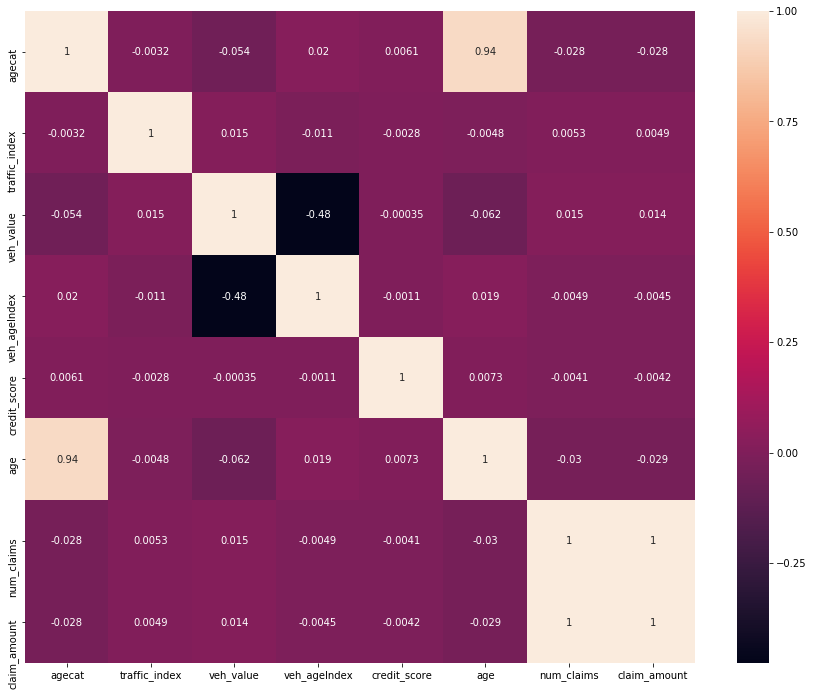

In [13]:
plt.figure(figsize=(15, 12))
sns.heatmap(data.corr(), annot=True)

we see some highly correlated independent variables.  Lets get through the vanilla model and then decided what features to drop.

**Split data set between categorical and continuous**

I will treat ordinal features as numeric data.  Doing this requires the assumption that the numeric space between each category is equal or close to equal.   To ignore the ordering would essentially mean we could delete columns for the drivers age, the traffic index, vehicle age and credit score; that would be too much useful information to lose and an extreme downside.  The downside to treating this data as numeric is that if the spread between bins are not equal, then our results may only be approximate.  I would posit that the approximate results would be more accurate than any model that disregarded them. 

In [14]:
# create continuous sub-DataFrame

continuous = data.copy()
for i in continuous:
    if continuous[i].dtype.name == 'category':
        continuous.drop(i, axis=1, inplace = True)
continuous.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 8 columns):
agecat           60948 non-null int64
traffic_index    60948 non-null int64
veh_value        60948 non-null float64
veh_ageIndex     60948 non-null int64
credit_score     60948 non-null int64
age              60948 non-null int64
num_claims       60948 non-null int64
claim_amount     60948 non-null float64
dtypes: float64(2), int64(6)
memory usage: 3.7 MB


In [15]:
# feature scaling -- Normalize the continuous data

scalar = StandardScaler()
cont_scaled = scalar.fit_transform(continuous)
print(type(cont_scaled))

<class 'numpy.ndarray'>


C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


scikit turned the Pandas DataFrame into a Numpy array and also stripped the column headers.  
Lets coerce into Pandas and put the headers back on.  

In [16]:
cont_scaled_df = pd.DataFrame(cont_scaled, columns = continuous.columns)
cont_scaled_df.head()

,agecat,traffic_index,veh_value,veh_ageIndex,credit_score,age,num_claims,claim_amount
0,0.361650,-0.183470,-0.377060,1.431967,-1.123803,0.351709,-0.262051,-0.261071
1,-0.340432,0.289758,-0.794601,1.431967,0.388199,-0.464101,-0.262051,-0.261071
2,1.063732,0.037370,-0.459008,0.437227,-0.197092,0.514871,-0.262051,-0.261071
3,-0.340432,-0.688247,-0.392669,0.437227,0.290651,-0.300939,-0.262051,-0.261071
4,-1.042514,0.037370,-0.115610,1.431967,0.632070,-0.844813,-0.262051,-0.261071


In [17]:
# create categorical sub-DataFrame

categorical = data.copy()
for i in categorical:
    if categorical[i].dtype.name != 'category':
        categorical.drop(i, axis = 1, inplace=True)
categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 4 columns):
gender       60948 non-null category
area         60948 non-null category
claim_ind    60948 non-null category
veh_body2    60948 non-null category
dtypes: category(4)
memory usage: 238.9 KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029E39C01C88>,
      dtype=object)

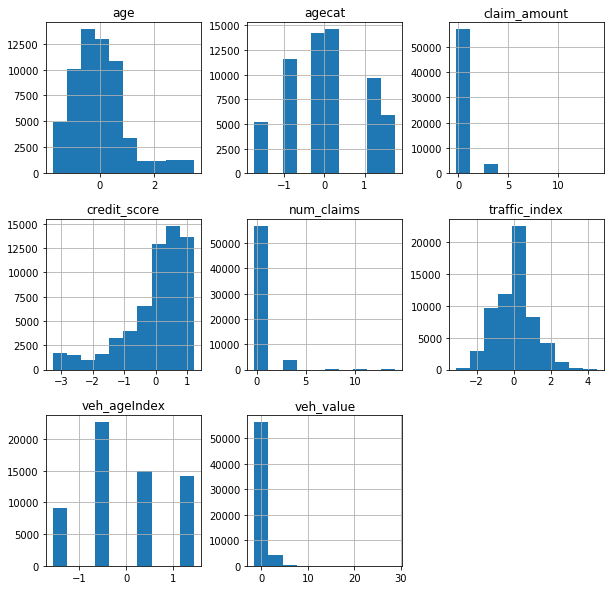

In [18]:
# inspect distributions for continuous data
cont_scaled_df.hist(figsize=(10,10))

**Get Dummies for categorical data**

In [19]:
categorical.head()

,gender,area,claim_ind,veh_body2
0,M,C,0,STNWG
1,M,C,0,SEDAN
2,M,A,0,SEDAN
3,M,B,0,UTE
4,M,D,0,STNWG


In [20]:
categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 4 columns):
gender       60948 non-null category
area         60948 non-null category
claim_ind    60948 non-null category
veh_body2    60948 non-null category
dtypes: category(4)
memory usage: 238.9 KB


In [21]:
categorical.veh_body2.value_counts()

SEDAN    19981
HBACK    16966
STNWG    14646
UTE       4108
TRUCK     1576
HDTOP     1506
MIBUS      794
COUPE      704
PANVN      667
Name: veh_body2, dtype: int64

In [22]:
# one-hot encode categorical data
dummies = pd.get_dummies(categorical.drop('claim_ind', axis=1))
dummies.head()

,gender_F,gender_M,area_A,area_B,area_C,area_D,area_E,area_F,veh_body2_COUPE,veh_body2_HBACK,veh_body2_HDTOP,veh_body2_MIBUS,veh_body2_PANVN,veh_body2_SEDAN,veh_body2_STNWG,veh_body2_TRUCK,veh_body2_UTE
0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


**concat the continuous and categorical DataFrames**

In [23]:
df = pd.concat([cont_scaled_df, dummies, categorical.claim_ind], axis = 1, sort=False)
df.head()

,agecat,traffic_index,veh_value,veh_ageIndex,credit_score,age,num_claims,claim_amount,gender_F,gender_M,area_A,area_B,area_C,area_D,area_E,area_F,veh_body2_COUPE,veh_body2_HBACK,veh_body2_HDTOP,veh_body2_MIBUS,veh_body2_PANVN,veh_body2_SEDAN,veh_body2_STNWG,veh_body2_TRUCK,veh_body2_UTE,claim_ind
0,0.361650,-0.183470,-0.377060,1.431967,-1.123803,0.351709,-0.262051,-0.261071,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,-0.340432,0.289758,-0.794601,1.431967,0.388199,-0.464101,-0.262051,-0.261071,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1.063732,0.037370,-0.459008,0.437227,-0.197092,0.514871,-0.262051,-0.261071,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,-0.340432,-0.688247,-0.392669,0.437227,0.290651,-0.300939,-0.262051,-0.261071,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,-1.042514,0.037370,-0.115610,1.431967,0.632070,-0.844813,-0.262051,-0.261071,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


# Logistic Regression Models

Lets check for any class imbalance in our target variable

In [24]:
df.claim_ind.value_counts()

0    56787
1     4161
Name: claim_ind, dtype: int64

Roughly 7% of the target data are True while 93% are False so, it looks like we do have class imbalance and will run SMOTE to fix it.

In [25]:
# define X and y 
X = df[df.columns[:-1]]
y = df.claim_ind

# resample X and y with SMOTE 
X_resampled, y_resampled = SMOTE().fit_sample(X, y)

# preview synthtic sample claim_ind distribution
print(pd.Series(y_resampled).value_counts())

1    56787
0    56787
dtype: int64


In [26]:
# split the resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = 42)

In [27]:
# create a Logistic Regression Object
logreg_classifier = LogisticRegression()

# fit a logistic regression model with default parameters
logreg_model = logreg_classifier.fit(X_train, y_train)
print(logreg_model)

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [28]:
# generating predictions
y_hat_train = logreg_model.predict(X_train)
y_hat_test = logreg_model.predict(X_test)

In [29]:
# initial evaluation

residuals_train_set = y_train - y_hat_train

residuals_test_set = y_test - y_hat_test

print("train set residuals:")
print(pd.Series(residuals_train_set).value_counts())
print(pd.Series(residuals_train_set).value_counts(normalize=True))

train set residuals:
0    79501
dtype: int64
0    1.0
dtype: float64


In [30]:
print("test set residuals:")
print(pd.Series(residuals_test_set).value_counts())
print(pd.Series(residuals_test_set).value_counts(normalize=True))

test set residuals:
0    34073
dtype: int64
0    1.0
dtype: float64


In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_hat_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17248
           1       1.00      1.00      1.00     16825

   micro avg       1.00      1.00      1.00     34073
   macro avg       1.00      1.00      1.00     34073
weighted avg       1.00      1.00      1.00     34073



The logistic classification model is performing perfectly for both the training and test sets.  Lets fix multicolinearity and see if we can get some realistic results

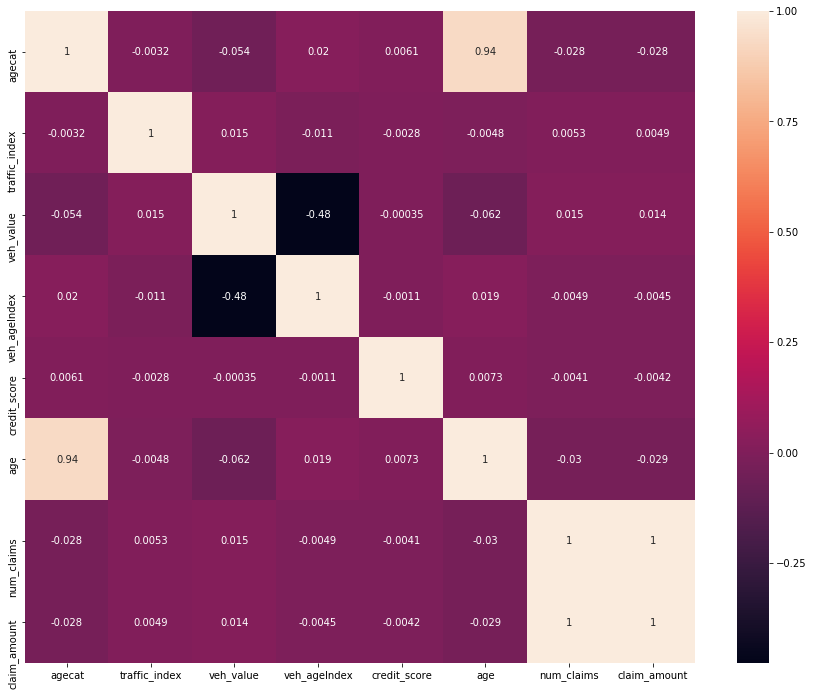

In [32]:
# view heatmap again
plt.figure(figsize=(15, 12))
sns.heatmap(cont_scaled_df.corr(), annot=True)

We clearly need to drop a couple more columns.  
Between age and age cat, lets keep age cat since the insurance company has already binned groups.  
And between num_claims and claim_amount, lets keep num_claims since it adds more context than dollar amount, ie, with dollar amount, we lose insight on if it represents one or multiple claims

In [33]:
# dropping 'age' and 'claim_amount'
cont_scaled_df_2 = cont_scaled_df.copy()
cont_scaled_df_2.drop(['age', 'claim_amount'], axis = 1, inplace = True)

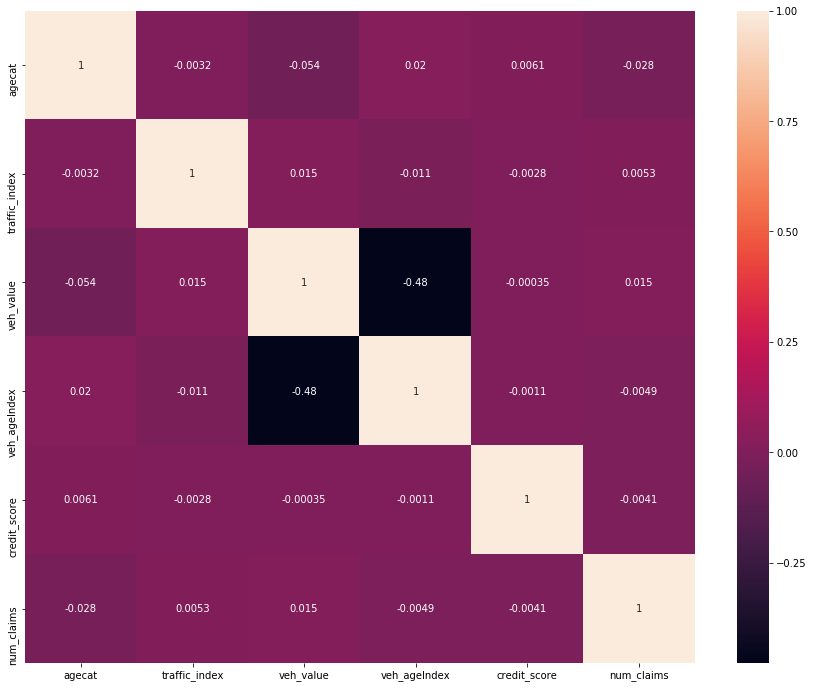

In [34]:
# correlation heatmap after removed of correlated features
plt.figure(figsize=(15, 12))
sns.heatmap(cont_scaled_df_2.corr(), annot=True)

In [35]:
df_2 = pd.concat([cont_scaled_df_2, dummies, categorical.claim_ind], axis = 1, sort=False)
df_2.head()

,agecat,traffic_index,veh_value,veh_ageIndex,credit_score,num_claims,gender_F,gender_M,area_A,area_B,area_C,area_D,area_E,area_F,veh_body2_COUPE,veh_body2_HBACK,veh_body2_HDTOP,veh_body2_MIBUS,veh_body2_PANVN,veh_body2_SEDAN,veh_body2_STNWG,veh_body2_TRUCK,veh_body2_UTE,claim_ind
0,0.361650,-0.183470,-0.377060,1.431967,-1.123803,-0.262051,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,-0.340432,0.289758,-0.794601,1.431967,0.388199,-0.262051,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1.063732,0.037370,-0.459008,0.437227,-0.197092,-0.262051,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,-0.340432,-0.688247,-0.392669,0.437227,0.290651,-0.262051,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,-1.042514,0.037370,-0.115610,1.431967,0.632070,-0.262051,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


In [36]:
# define X and y 
X2 = df_2[df_2.columns[:-1]]
y2 = df_2.claim_ind

# resample X and y with SMOTE 
X_resampled_2, y_resampled_2 = SMOTE().fit_sample(X2, y2)

# split the resampled data into train and test sets
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_resampled_2, y_resampled_2, test_size = 0.3, random_state = 42)

In [37]:
# fit a logistic regression model with default parameters
logreg_model_2 = logreg_classifier.fit(X_train_2, y_train_2)
print(logreg_model_2)

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [38]:
# generating predictions
y_hat_train_2 = logreg_model.predict(X_train_2)
y_hat_test_2 = logreg_model_2.predict(X_test_2)

In [39]:
# initial evaluation

residuals_train_set_2 = y_train_2 - y_hat_train_2

residuals_test_set_2 = y_test_2 - y_hat_test_2

print("train set residuals:")
print(pd.Series(residuals_train_set_2).value_counts())
print(pd.Series(residuals_train_set_2).value_counts(normalize=True))

train set residuals:
0    79501
dtype: int64
0    1.0
dtype: float64


In [40]:
print("test set residuals:")
print(pd.Series(residuals_test_set_2).value_counts())
print(pd.Series(residuals_test_set_2).value_counts(normalize=True))

test set residuals:
0    34073
dtype: int64
0    1.0
dtype: float64


In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test_2,y_hat_test_2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17248
           1       1.00      1.00      1.00     16825

   micro avg       1.00      1.00      1.00     34073
   macro avg       1.00      1.00      1.00     34073
weighted avg       1.00      1.00      1.00     34073



Removing multicolinearity had no effecto on model results which are still perfect and unrealistic.  Lets move on to Random Forests for (hopefully) more insight which might tell us that Logistic Regression is simply not sensitive enough for thid data.

# Random Forest

In [42]:
RF_data = df_2.copy()

RF_X = RF_data.drop(['claim_ind'], axis=1)
RF_y = RF_data.claim_ind

In [43]:
RF_data_train, RF_data_test, RF_target_train, RF_target_test = train_test_split(RF_X, RF_y, test_size = 0.3, random_state=42) 


In [44]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(RF_data_train, RF_target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [45]:
forest.score(RF_data_train, RF_target_train)

1.0

In [46]:
forest.score(RF_data_test, RF_target_test)

1.0

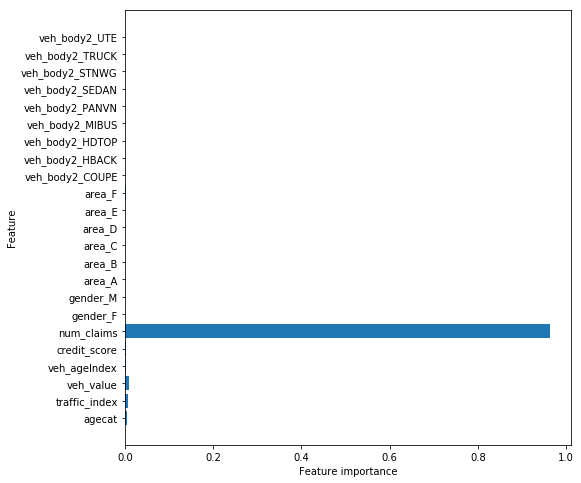

In [47]:
def plot_feature_importances(model):
    n_features = RF_data_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), RF_data_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(forest)

num_claims is clearly distorting things in the model.  Claim_amt was removed due to its correlation with num_claims but it looks like they both need to be removed. 

Lets remove num_claims and run Random Forest again.

In [48]:
# create new dataFrame object and drop num_claims
RF_data_2 = df_2.copy().drop('num_claims', axis=1)

In [49]:
RF_data_2.head()

,agecat,traffic_index,veh_value,veh_ageIndex,credit_score,gender_F,gender_M,area_A,area_B,area_C,area_D,area_E,area_F,veh_body2_COUPE,veh_body2_HBACK,veh_body2_HDTOP,veh_body2_MIBUS,veh_body2_PANVN,veh_body2_SEDAN,veh_body2_STNWG,veh_body2_TRUCK,veh_body2_UTE,claim_ind
0,0.361650,-0.183470,-0.377060,1.431967,-1.123803,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,-0.340432,0.289758,-0.794601,1.431967,0.388199,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1.063732,0.037370,-0.459008,0.437227,-0.197092,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,-0.340432,-0.688247,-0.392669,0.437227,0.290651,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,-1.042514,0.037370,-0.115610,1.431967,0.632070,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


In [51]:
# define predictor set and target series
RF_X_2 = RF_data_2.drop(['claim_ind'], axis=1)
RF_y_2 = RF_data_2.claim_ind

# split data into train and test sets
RF_data_train_2, RF_data_test_2, RF_target_train_2, RF_target_test_2 = train_test_split(RF_X, RF_y, test_size = 0.3, 
                                                                                        random_state=42) 
# create a random forest classifier object
forest_2 = RandomForestClassifier(n_estimators=100, max_depth= 5)
# fit the model
forest_2.fit(RF_data_train_2, RF_target_train_2)

print(f" Accuracy of model on training set: {forest_2.score(RF_data_train_2, RF_target_train_2)}")
print(f" Accuracy of model on test set: {forest_2.score(RF_data_test_2, RF_target_test_2)}")

 Accuracy of model on training set: 1.0
 Accuracy of model on test set: 1.0
